Aleksandra Bednarczuk

# Predictors of elderly citizens willingness to stay in the neighbourhood
# Logistic regression

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from imblearn.over_sampling import SMOTE

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from scipy import stats

In [3]:
data = pd.read_pickle("survey_transformed.pkl")

In [4]:
data.head()

,ANY,Stay_in_the_same_neighborhood,Gender,Time_living_in_BCN,Time_living_in_barri,BCN_if_has_improved,BCN_if_will_improve,BCN_satisfaction_of_living,BCN_city_management,GARBAGE COLLECTION,...,Compare_if_has_improved,Compare_if_will_improve,Compare_satisfaction_of_living,Compare_city_management,Compare_transport,Barri_over_BCN_if_has_improved,Barri_over_BCN_if_will_improve,Barri_over_BCN_satisfaction_of_living,Barri_over_BCN_city_management,Barri_over_BCN_transport
0,2011,1,1,MORE THAN 10 YEARS,MORE THAN 10 YEARS,-1,-1,3,1,1,...,Equal,Equal,BCN over Barri,Equal,Equal,0,0,0,0,0
1,2011,1,1,I HAVE ALWAYS LIVED IN THE CITY,MORE THAN 10 YEARS,-1,-1,4,1,-1,...,Barri over BCN,Barri over BCN,Equal,Equal,Barri over BCN,1,1,0,0,1
2,2011,1,1,I HAVE ALWAYS LIVED IN THE CITY,MORE THAN 10 YEARS,0,1,4,-1,1,...,BCN over Barri,BCN over Barri,Equal,Barri over BCN,Equal,0,0,0,1,0
3,2011,1,1,MORE THAN 10 YEARS,LESS THAN 10 YEARS,-1,0,4,1,1,...,Equal,BCN over Barri,Equal,Equal,Equal,0,0,0,0,0
4,2011,0,0,I HAVE ALWAYS LIVED IN THE CITY,MORE THAN 10 YEARS,0,0,4,-1,-1,...,Equal,Equal,BCN over Barri,Barri over BCN,Barri over BCN,0,0,0,1,1


In [5]:
data.shape

(13742, 53)

In [6]:
for i in data.columns:
    if data[i].isnull().sum() > 1 :
        print(i, data[i].isnull().sum())

Means_of_transport 2


In [7]:
data = data.dropna()

In [8]:
data_train = data.query('ANY < 2019')
data_test = data.query('ANY == 2019')

In [9]:
print("Train dataset shape:", data_train.shape, " Test dataset shape:", data_test.shape)

Train dataset shape: (12258, 53)  Test dataset shape: (1482, 53)


In [10]:
independent = data.columns.tolist()
for i in ['ANY', 'Stay_in_the_same_neighborhood']:
    independent.remove(i)

In [11]:
dependent = 'Stay_in_the_same_neighborhood'

In [12]:
independent

['Gender',
 'Time_living_in_BCN',
 'Time_living_in_barri',
 'BCN_if_has_improved',
 'BCN_if_will_improve',
 'BCN_satisfaction_of_living',
 'BCN_city_management',
 'GARBAGE COLLECTION',
 'STREETS CLEANING',
 'NOISE',
 'GREEN AREAS',
 'PUBLIC LIGHTING',
 'URBANISM',
 'ASPHALT AND STREET CONSERVATION',
 'FACADES AND BUILDING CONSERVATION',
 'CIRCULATION',
 'PARKING',
 'MUNICIPAL POLICE',
 'CITIZEN SECURITY IN THE CITY AS A WHOLE',
 'CITIZEN SECURITY IN THE NEIGHBORHOOD',
 'SPORTS FACILITIES',
 'CITIZEN INFORMATION AND ATTENTION SERVICES',
 'SOCIAL SERVICES CENTERS',
 'CULTURAL ACTIVITIES',
 'POPULAR FESTIVALS',
 'MUNICIPAL MARKETS',
 'PUBLIC LIBRARIES',
 'Means_of_transport',
 'BCN_transport',
 'Barri_transport',
 'Barri_if_has_improved',
 'Barri_if_will_improve',
 'Barri_satisfaction_of_living',
 'Barri_comparison',
 'Barri_city_management',
 'Owns_a_car',
 'House_M2',
 'Social_class',
 'Voted',
 'Born_in_BCN',
 'Living_alone',
 'Compare_if_has_improved',
 'Compare_if_will_improve',
 'Co

In [13]:
for i in ['BCN_if_has_improved', 'BCN_if_will_improve', 'BCN_satisfaction_of_living', 'BCN_city_management', 
          'BCN_transport', 'Barri_transport','Barri_if_has_improved', 'Barri_if_will_improve',
          'Barri_satisfaction_of_living', 'Barri_city_management', 'Compare_if_has_improved',
          'Compare_if_will_improve', 'Compare_satisfaction_of_living', 'Compare_city_management', 'Compare_transport',]:
    independent.remove(i)

In [14]:
x = data_train[independent]
y = data_train[dependent]

In [15]:
x = pd.get_dummies(x, drop_first = True)

In [16]:
# Training dataset is highly unbalanced
data_train.groupby(['Stay_in_the_same_neighborhood']).size()

Stay_in_the_same_neighborhood
0    2826
1    9432
dtype: int64

In [17]:
os = SMOTE(random_state=0)
columns = x.columns
os_data_x, os_data_y=os.fit_sample(x, y)
os_data_x = pd.DataFrame(data=os_data_x, columns=columns )
os_data_y= pd.DataFrame(data=os_data_y, columns=['Stay_in_the_same_neighborhood'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_x))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Stay_in_the_same_neighborhood']==0]))
print("Number of subscription",len(os_data_y[os_data_y['Stay_in_the_same_neighborhood']==1]))
print("Proportion of no subscription data in oversampled data is ",
      len(os_data_y[os_data_y['Stay_in_the_same_neighborhood']==0])/len(os_data_x))
print("Proportion of subscription data in oversampled data is ",
      len(os_data_y[os_data_y['Stay_in_the_same_neighborhood']==1])/len(os_data_x))

length of oversampled data is  18864
Number of no subscription in oversampled data 9432
Number of subscription 9432
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [18]:
logit_model = sm.Logit(os_data_y,os_data_x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.553832
         Iterations 6
                                      Results: Logit
Model:                   Logit                             Pseudo R-squared:     0.201     
Dependent Variable:      Stay_in_the_same_neighborhood     AIC:                  20990.9745
Date:                    2021-03-24 23:31                  BIC:                  21367.5350
No. Observations:        18864                             Log-Likelihood:       -10447.   
Df Model:                47                                LL-Null:              -13076.   
Df Residuals:            18816                             LLR p-value:          0.0000    
Converged:               1.0000                            Scale:                1.0000    
No. Iterations:          6.0000                                                            
-------------------------------------------------------------------------------------------
                 

In [19]:
pd.DataFrame(result.pvalues.sort_values(ascending=False))

,0
Means_of_transport_PUBLIC TRANSPORT,9.800009e-01
CULTURAL ACTIVITIES,6.402323e-01
Time_living_in_BCN_LESS THAN 10 YEARS,6.011476e-01
CITIZEN SECURITY IN THE CITY AS A WHOLE,3.587296e-01
GREEN AREAS,3.488731e-01
STREETS CLEANING,3.393945e-01
SPORTS FACILITIES,2.752830e-01
House_M2_< 50 M2,1.937121e-01
Owns_a_car,1.167842e-01
Time_living_in_BCN_MORE THAN 10 YEARS,1.124827e-01


In [20]:
features = os_data_x.columns.tolist()
for i in ['CULTURAL ACTIVITIES', 'CITIZEN SECURITY IN THE CITY AS A WHOLE',
          'GREEN AREAS', 'STREETS CLEANING', 'SPORTS FACILITIES', 'Owns_a_car']:
    features.remove(i)

In [21]:
os_data_x = os_data_x[features]

In [22]:
logit_model = sm.Logit(os_data_y,os_data_x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.554001
         Iterations 6
                                      Results: Logit
Model:                   Logit                             Pseudo R-squared:     0.201     
Dependent Variable:      Stay_in_the_same_neighborhood     AIC:                  20985.3380
Date:                    2021-03-24 23:31                  BIC:                  21314.8284
No. Observations:        18864                             Log-Likelihood:       -10451.   
Df Model:                41                                LL-Null:              -13076.   
Df Residuals:            18822                             LLR p-value:          0.0000    
Converged:               1.0000                            Scale:                1.0000    
No. Iterations:          6.0000                                                            
-------------------------------------------------------------------------------------------
                 

In [23]:
margeff = result.get_margeff()
print(margeff.summary())

             Logit Marginal Effects             
Dep. Variable:     Stay_in_the_same_neighborhood
Method:                                     dydx
At:                                      overall
                                                dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Gender                                         0.0478      0.007      7.316      0.000       0.035       0.061
GARBAGE COLLECTION                            -0.0926      0.007    -12.736      0.000      -0.107      -0.078
NOISE                                          0.0413      0.004     11.502      0.000       0.034       0.048
PUBLIC LIGHTING                               -0.0503      0.006     -8.627      0.000      -0.062      -0.039
URBANISM                                       0.0181      0.005      3.473      0.001       0.008       0.028
ASPHALT AND STREET CONSERVA

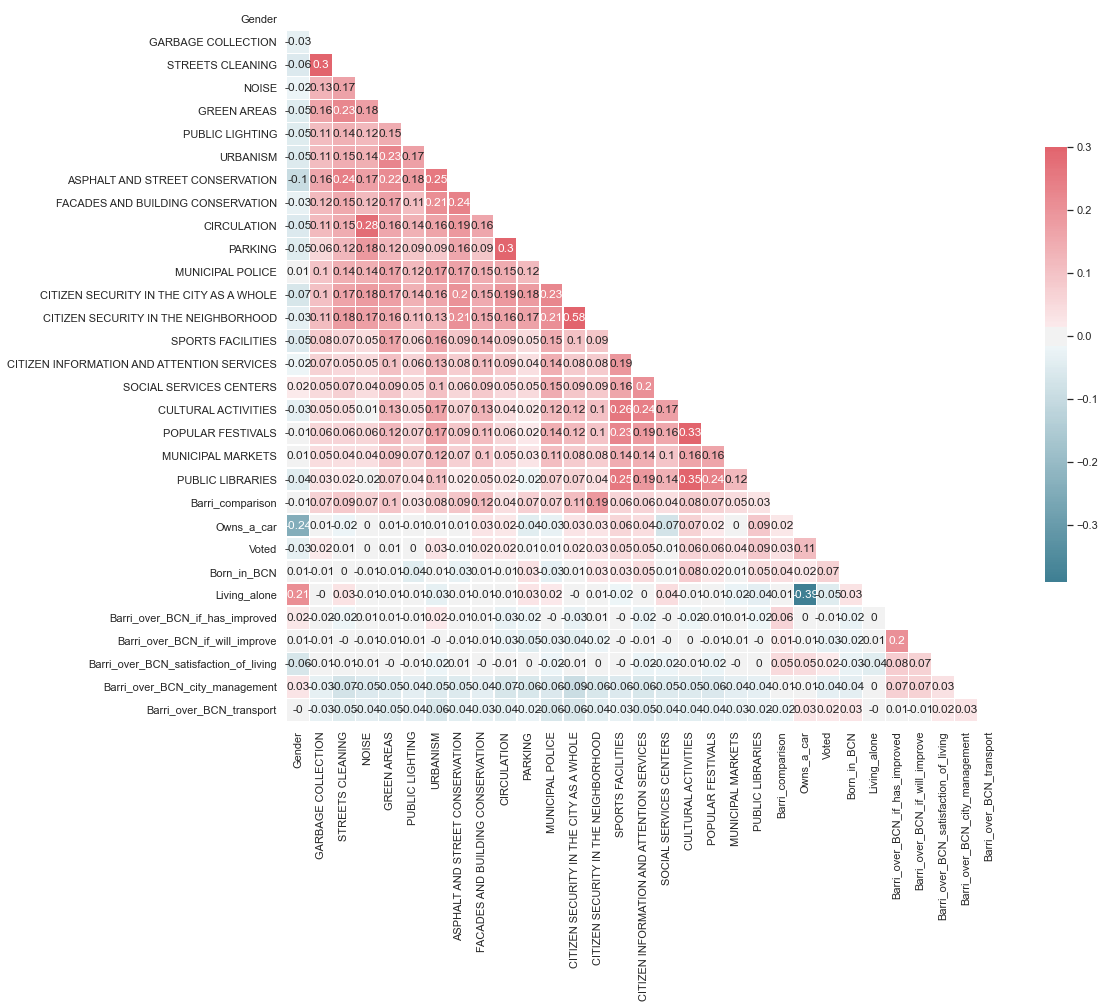

In [24]:
import seaborn as sns # just a conventional alias, don't know why
sns.set(style="white")

corr = data_train[independent].corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot = corr.round(2), linewidths=.5, cbar_kws={"shrink": .5})

In [25]:
data_test = pd.get_dummies(data_test)

In [26]:
data_test.groupby(['Stay_in_the_same_neighborhood']).size()

Stay_in_the_same_neighborhood
0     417
1    1065
dtype: int64

In [27]:
print("Rate if we predict 1 for whole dataset: ", data_test.groupby(['Stay_in_the_same_neighborhood']).size()[1]/(data_test.groupby(['Stay_in_the_same_neighborhood']).size()[0]+data_test.groupby(['Stay_in_the_same_neighborhood']).size()[1]))

Rate if we predict 1 for whole dataset:  0.7186234817813765


In [28]:
x_test = data_test[features]
y_test = data_test[dependent]

In [29]:
x_test.shape, os_data_x.shape

((1482, 42), (18864, 42))

In [30]:
# logit_model = sm.Logit(y_test,x_test)
# result=logit_model.fit()
# print(result.summary2())

In [31]:
# yhat = logit_model.predict(x_test)
# prediction = list(map(y_test, yhat))
logreg = LogisticRegression(penalty='none')
logreg.fit(os_data_x,os_data_y)
y_pred=logreg.predict(x_test)

C:\Users\THINK\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\THINK\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [32]:
y_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [33]:
# confusion matrix 
cm = confusion_matrix(y_test, y_pred)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, y_pred))

# r2 of the model 
print('R2 = ', r2_score(y_test, y_pred))

Confusion Matrix : 
 [[153 264]
 [195 870]]
Test accuracy =  0.6902834008097166
R2 =  -0.5317053399533893


In [34]:
roc_auc_score(y_test, y_pred)

0.5919039416354241

In [35]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.44      0.37      0.40       417
           1       0.77      0.82      0.79      1065

    accuracy                           0.69      1482
   macro avg       0.60      0.59      0.60      1482
weighted avg       0.68      0.69      0.68      1482



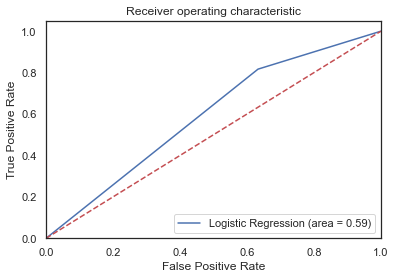

In [36]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict(x_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()